In [6]:
import os
os.chdir('/Users/nick/Documents/school/research/EfficientLPR')
from scipy.io import loadmat
import numpy as np
from cv2 import cv2
import matplotlib.pyplot as plt

In [49]:
in_dir = 'data/raw/comp-cars'
surv_dir = in_dir + '/sv_data'
label_mat = loadmat(surv_dir + '/sv_make_model_name')

In [51]:
web_dir = in_dir + '/data'
label_dir = web_dir + '/label'

makes = [x[0][0] for x in loadmat(web_dir + '/misc/make_model_name.mat')["make_names"]]

side_view_id = 3

# will have columns [fname (of image), make, year, x1, y1, x2, y2]
annos = []

for make_id in sorted(os.listdir(label_dir)):
    make_dir = f'{label_dir}/{make_id}'

    for model_id in sorted(os.listdir(make_dir)):
        model_path = f'{make_dir}/{model_id}'

        for year in sorted(os.listdir(model_path)):
            leaf_path = f'{model_path}/{year}'
            
            for fname in sorted(os.listdir(leaf_path)):
                file_path = f'{leaf_path}/{fname}'
                with open(file_path, 'r') as f:
                    file_data = f.read().strip().split('\n')
                    viewpoint_id = int(file_data[0])
                    bbox = file_data[2].split(' ')
                    if not (viewpoint_id == side_view_id):
                        annos.append(["image/" + "/".join(file_path[:-4].split("/")[5:]) + '.jpg',
                            makes[int(make_id)-1], year, *bbox])

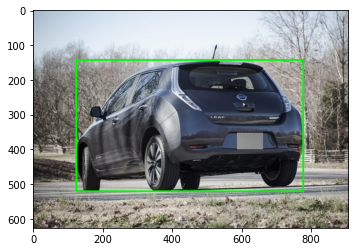

In [52]:
import random
annos = np.array(annos)
size = len(annos)
sample = annos[random.randint(0, size)]
img = cv2.imread(web_dir + '/' + sample[0])
p1 = (int(sample[3]), int(sample[4]))
p2 = (int(sample[5]), int(sample[6]))
img = cv2.rectangle(img, p2, p1, (0,250,0), 3)
plt.imshow(img[:,:,::-1])